In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE
from src.utils import audio_to_spectrogram

In [44]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda RingMod"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES_PER_SETTING = 100
NUM_SETTINGS = 20
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/z63wn50r/checkpoints/epoch=1292-step=808125.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
PEAK_NORMALISE = True

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [46]:
def dafx_from_name(dafx_name):
    if dafx_name.lower() == "clean":
        return NullDAFXWrapper()
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [47]:
def get_dataset(dafx):
    dataset = PairedAudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES_PER_SETTING,
        augmentations={},
        length=131_072,
        effect_input=False,
        effect_output=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [48]:
dafx = dafx_from_name(DAFX_NAME)

In [49]:
def get_interpolated_settings(dafx, setting_idx, num_samples=100):
    num_settings = len(dafx.param_names)

    assert(setting_idx <= num_settings)

    settings = []
    for i in np.linspace(0,1, num_samples):
        s = torch.ones(num_settings) * 0.5
        s[setting_idx] = i
        settings.append(s)

    return settings

In [50]:
settings_to_apply = get_interpolated_settings(dafx, 1, 10)

In [51]:
settings_to_apply

[tensor([0.5000, 0.0000, 0.5000]),
 tensor([0.5000, 0.1111, 0.5000]),
 tensor([0.5000, 0.2222, 0.5000]),
 tensor([0.5000, 0.3333, 0.5000]),
 tensor([0.5000, 0.4444, 0.5000]),
 tensor([0.5000, 0.5556, 0.5000]),
 tensor([0.5000, 0.6667, 0.5000]),
 tensor([0.5000, 0.7778, 0.5000]),
 tensor([0.5000, 0.8889, 0.5000]),
 tensor([0.5000, 1.0000, 0.5000])]

In [52]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT).to(device)
model.eval()
beta = str(model.hparams.vae_beta).replace(".", "p")

In [53]:
model.device

device(type='cuda', index=0)

In [54]:
latent_embeddings = dict()

In [55]:
dataset = get_dataset(dafx_from_name('clean'))

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 50596.13it/s]


Loaded 88 files for train = 66.89 hours.


In [56]:
from tqdm import tqdm

for i in range(dafx.get_num_params()):
    setting_name = dafx.idx_to_param_map[i]
    print(f"Interpolating setting: {setting_name}")
    embeddings = []
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    for setting in settings_to_apply:
        print(f"Applying setting: {setting}")
        for batch in tqdm(dataset):
            x, y = batch

            # Apply setting to audio
            y = dafx.apply(y, setting)
            y = y.unsqueeze(0).unsqueeze(0)

            x_s = audio_to_spectrogram(signal=x)
            y_s = audio_to_spectrogram(signal=y)

            X = torch.concat([x_s, y_s], dim=1).to("cuda")

            _, _, _, z = model(X)

            embeddings.append(z.cpu().detach().numpy())

        latent_embeddings[setting_name] = np.array(embeddings)


Interpolating setting: freq_hz
Applying setting: tensor([0.0000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.86it/s]


Applying setting: tensor([0.0526, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.51it/s]


Applying setting: tensor([0.1053, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.59it/s]


Applying setting: tensor([0.1579, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.06it/s]


Applying setting: tensor([0.2105, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.41it/s]


Applying setting: tensor([0.2632, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 31.63it/s]


Applying setting: tensor([0.3158, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.77it/s]


Applying setting: tensor([0.3684, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.97it/s]


Applying setting: tensor([0.4211, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Applying setting: tensor([0.4737, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Applying setting: tensor([0.5263, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.21it/s]


Applying setting: tensor([0.5789, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 28.83it/s]


Applying setting: tensor([0.6316, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.33it/s]


Applying setting: tensor([0.6842, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 28.74it/s]


Applying setting: tensor([0.7368, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.93it/s]


Applying setting: tensor([0.7895, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


Applying setting: tensor([0.8421, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.65it/s]


Applying setting: tensor([0.8947, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 31.29it/s]


Applying setting: tensor([0.9474, 0.5000, 0.5000])


100%|██████████| 100/100 [00:04<00:00, 20.77it/s]


Applying setting: tensor([1.0000, 0.5000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.50it/s]


Interpolating setting: fine_hz
Applying setting: tensor([0.5000, 0.0000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.02it/s]


Applying setting: tensor([0.5000, 0.0526, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.27it/s]


Applying setting: tensor([0.5000, 0.1053, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 31.48it/s]


Applying setting: tensor([0.5000, 0.1579, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.33it/s]


Applying setting: tensor([0.5000, 0.2105, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 32.36it/s]


Applying setting: tensor([0.5000, 0.2632, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.64it/s]


Applying setting: tensor([0.5000, 0.3158, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 25.99it/s]


Applying setting: tensor([0.5000, 0.3684, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Applying setting: tensor([0.5000, 0.4211, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 31.80it/s]


Applying setting: tensor([0.5000, 0.4737, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 28.97it/s]


Applying setting: tensor([0.5000, 0.5263, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 32.30it/s]


Applying setting: tensor([0.5000, 0.5789, 0.5000])


100%|██████████| 100/100 [00:05<00:00, 19.70it/s]


Applying setting: tensor([0.5000, 0.6316, 0.5000])


100%|██████████| 100/100 [00:05<00:00, 19.78it/s]


Applying setting: tensor([0.5000, 0.6842, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.01it/s]


Applying setting: tensor([0.5000, 0.7368, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 31.24it/s]


Applying setting: tensor([0.5000, 0.7895, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 31.61it/s]


Applying setting: tensor([0.5000, 0.8421, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 30.04it/s]


Applying setting: tensor([0.5000, 0.8947, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 26.02it/s]


Applying setting: tensor([0.5000, 0.9474, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 31.27it/s]


Applying setting: tensor([0.5000, 1.0000, 0.5000])


100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


Interpolating setting: feedback
Applying setting: tensor([0.5000, 0.5000, 0.0000])


100%|██████████| 100/100 [00:04<00:00, 23.24it/s]


Applying setting: tensor([0.5000, 0.5000, 0.0526])


100%|██████████| 100/100 [00:03<00:00, 30.11it/s]


Applying setting: tensor([0.5000, 0.5000, 0.1053])


100%|██████████| 100/100 [00:03<00:00, 32.23it/s]


Applying setting: tensor([0.5000, 0.5000, 0.1579])


100%|██████████| 100/100 [00:03<00:00, 31.56it/s]


Applying setting: tensor([0.5000, 0.5000, 0.2105])


100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


Applying setting: tensor([0.5000, 0.5000, 0.2632])


100%|██████████| 100/100 [00:03<00:00, 29.95it/s]


Applying setting: tensor([0.5000, 0.5000, 0.3158])


100%|██████████| 100/100 [00:03<00:00, 29.05it/s]


Applying setting: tensor([0.5000, 0.5000, 0.3684])


100%|██████████| 100/100 [00:03<00:00, 25.80it/s]


Applying setting: tensor([0.5000, 0.5000, 0.4211])


100%|██████████| 100/100 [00:03<00:00, 31.28it/s]


Applying setting: tensor([0.5000, 0.5000, 0.4737])


100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5263])


100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Applying setting: tensor([0.5000, 0.5000, 0.5789])


100%|██████████| 100/100 [00:03<00:00, 29.62it/s]


Applying setting: tensor([0.5000, 0.5000, 0.6316])


100%|██████████| 100/100 [00:03<00:00, 30.38it/s]


Applying setting: tensor([0.5000, 0.5000, 0.6842])


100%|██████████| 100/100 [00:03<00:00, 29.36it/s]


Applying setting: tensor([0.5000, 0.5000, 0.7368])


100%|██████████| 100/100 [00:03<00:00, 31.45it/s]


Applying setting: tensor([0.5000, 0.5000, 0.7895])


100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Applying setting: tensor([0.5000, 0.5000, 0.8421])


100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Applying setting: tensor([0.5000, 0.5000, 0.8947])


100%|██████████| 100/100 [00:03<00:00, 30.26it/s]


Applying setting: tensor([0.5000, 0.5000, 0.9474])


100%|██████████| 100/100 [00:03<00:00, 31.83it/s]


Applying setting: tensor([0.5000, 0.5000, 1.0000])


100%|██████████| 100/100 [00:03<00:00, 29.55it/s]


In [57]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [58]:
data.shape

(6000, 4096)

In [59]:
import umap

In [60]:
reducer = umap.UMAP().fit(data)

In [61]:
import seaborn as sns

sns.set()

In [62]:
EXPERIMENT_NAME = f"{CHECKPOINT_ID}_{DAFX_NAME.split()[-1]}_{NUM_SETTINGS}settings"

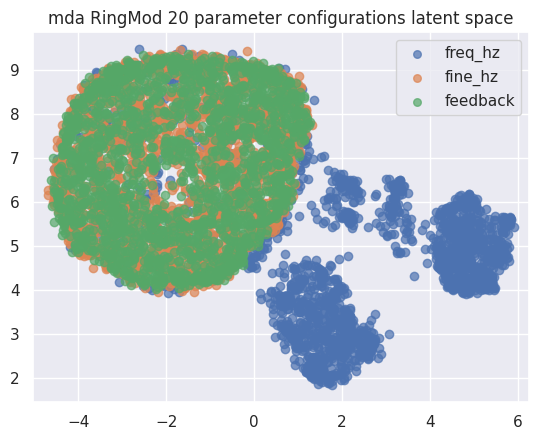

In [63]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.7)

plt.gca().set_aspect('equal', 'datalim')
plt.title(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

figname = f"./figures/latent_param_interpolation/{EXPERIMENT_NAME}_beta{beta}_latent_embeddings.png"
plt.savefig(figname)

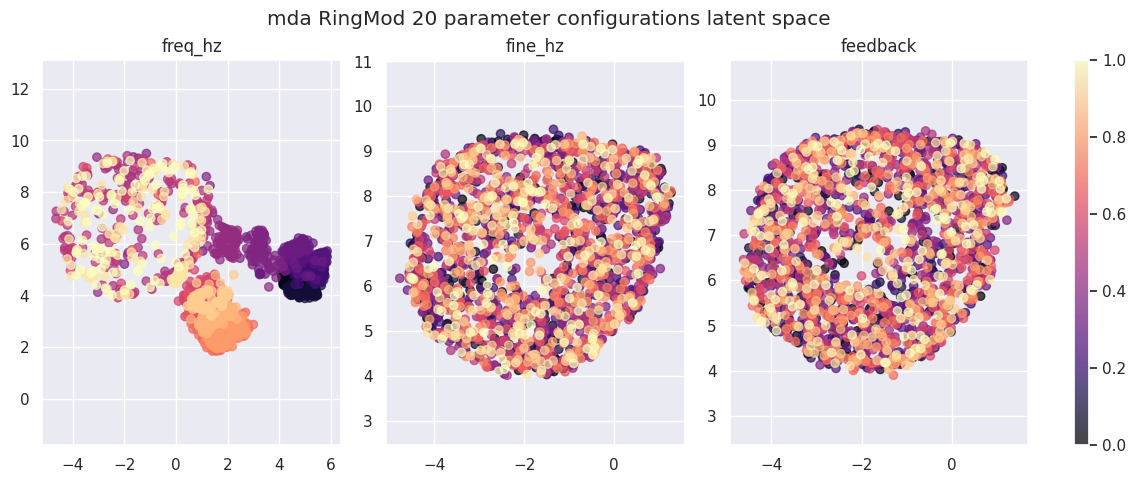

In [64]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(4.5*dafx.get_num_params(), 5))
gs = gridspec.GridSpec(1, dafx.get_num_params() + 1, width_ratios=[1]*dafx.get_num_params() + [0.05])

for i in range(dafx.get_num_params()):
    param_name = dafx.idx_to_param_map[i]
    X = latent_embeddings[param_name]

    embeds = reducer.transform(X.squeeze())
    settings_to_apply = get_interpolated_settings(dafx, i, NUM_SETTINGS)
    colours = np.array([np.array([setting[i]]*NUM_EXAMPLES_PER_SETTING) for setting in settings_to_apply])

    ax = fig.add_subplot(gs[0, i])
    sc = ax.scatter(x=embeds[:,0], y=embeds[:,1], alpha=0.7, c=colours, vmin=0, vmax=1, cmap='magma')

    ax.set_title(param_name)
    ax.set_aspect('equal', 'datalim')

plt.suptitle(f"{DAFX_NAME} {NUM_SETTINGS} parameter configurations latent space")

cax = fig.add_subplot(gs[0, -1])
plt.colorbar(sc, cax=cax)

fig.subplots_adjust(right=0.9)

figname = f"./figures/latent_param_interpolation/{EXPERIMENT_NAME}_beta{beta}_latent_cmap.png"
plt.savefig(figname)